# Process Overview and Data Preparation
### Data Source Background
Climate Canada provides access to historical weather data through its historical climate data app [1]. The data is produced by sensors installed at weather stations located at geographically dispersed locations accross Canada.

> A **weather station** is a facility, either on land or sea, with instruments and equipment for measuring atmospheric conditions to provide information for weather forecasts and to study the weather and climate. [2]

Data is available at monthly, daily, and hourly intervals on a per-weather station basis with data missing for some combinations of interval, station, and observation period e.g. monthly data for London weather stations. The availability for a particular time interval (e.g. for the month of December) varies accross stations; some stations are missing entire months of data. This should not pose a significant problem as we are not interested in station-level measurements but rather overall weather trends in London, Ontario. Data accross stations is aggregated so that the daily measurements from each station are averaged to produce a single measurement value (see [1.5](#1.5-Daily-Observation-Data)). Our hope is that when data is missing from one station, it is generally available from another.

The datasets for observational periods (monthly, daily, hourly) provide different sets of variables. Daily weather data (available through the Climate Canada website by year/month) contains both precipitation and weather data and is the most suitable level of granularity for this analysis so it's the level of granularity that will be used here.


### Retrieving Weather Data
Historical weather data produced by weather stations can be obtained through Climate Canada's web app which accepts queries for station names, province, or proximity as shown below.

<img src ="images/station_search.png" style="height: 400px;" />

After selecting a station, data can be requested at hourly, daily, or monthly intervals.

<img src ="images/station_result.png" style="height: 400px;" />

This analysis will focus on data from weather stations deployed in London Ontario, Canada so the search term used to find relevant stations and the associated data included only the keyword "London".  

After using the Climate Canada web app to identify stations in London Ontario, only those with monthly data (data for every day of the month) available for at least five years were considered for the analysis. The London CS, London Airport, and London A stations met this critera and monthly data for the stations were retrieved from Climate Canada's web application using a Python program built using the web scraping framework [4].  The program automates the data retrieval process by generating search requests for station data for the stations of interest for every month from January 1, 2010 to February 10, 2019 and uses XPath [5] to extract data from HTML tables, the structure of which is shown below.  

<img src ="images/station_report.png" style="height: 400px;" />

All of the data is outputted to a CSV file where each row represents a day of observed data from each one of the stations. Code for the web scraper can be found in the project's GitHub repository [6].  The code can be cloned from GitHub and the CSV can be populated with data upto today's date by running the following at the command line:

```
cd ../webcrawler
scrapy crawl monthly_weather_spider

```

## Data Prep

In [1]:
import pandas as pd
# import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Load daily weather data produced by web scraper
dwd = pd.read_csv('../data/raw/scrapy-weather-data.csv', parse_dates=['date'])

The list of variables included in the dataset and their original names / descriptions [3].

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.read_csv('../data/raw/variable_descriptions.csv', sep='|')

,Variable Name,Official Variable Name,Official Variable Description
0,station,station name,The station name is the official name of any meteorological station in the National Climate Archive as administered by the Meteorological Service of Canada.
1,date,NaN,The date of the observation
2,maxTemp,maximum temperature (°C),The highest temperature in degrees Celsius (°C) observed at a location for a specified time interval.
3,minTemp,minimum temperature (°C),The lowest temperature in degrees Celsius (°C) observed at a location for a specified time interval.
4,meanTemp,mean temperature (°C),The mean temperature in degrees Celsius (°C) is defined as the average of the maximum and minimum temperature at a location for a specified time interval.
5,heatDegDays,heating degree-days,"Heating degree-days for a given day are the number of degrees Celsius that the mean temperature is below 18 °C. If the temperature is equal to or greater than 18 °C, then the number will be zero. For example, a day with a mean temperature of 15.5 °C has 2.5 heating degree-days; a day with a mean temperature of 20.5 °C has zero heating degree-days. Heating degree-days are used primarily to estimate the heating requirements of buildings."
6,coolDegDays,cooling degree-days,"Cooling degree-days for a given day are the number of degrees Celsius that the mean temperature is above 18 °C. If the temperature is equal to or less than 18 °C, then the number will be zero. For example, a day with a mean temperature of 20.5 °C has 2.5 cooling degree-days; a day with a mean temperature of 15.5 °C has zero cooling degree-days. Cooling degree-days are used primarily to estimate the air-conditioning requirements of buildings."
7,totalRainMM,total rain (mm),"The total rainfall, or amount of all liquid precipitation in millimetres (mm) such as rain, drizzle, freezing rain, and hail, observed at the location during a specified time interval."
8,totalSnowCM,total snow (cm),"The total snowfall, or amount of frozen (solid) precipitation in centimetres (cm), such as snow and ice pellets, observed at the location during a specified time interval."
9,totalPrecipMM,total precipitation (mm),"The sum of the total rainfall and the water equivalent of the total snowfall in millimetres (mm), observed at the location during a specified time interval."


Look at the first few observations

In [4]:
dwd.head()

,station,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,London CS,2010-06-01,24.0,14.7,19.4,0.0,1.4,NaN,NaN,13.8,,NaN,NaN
1,London CS,2010-06-02,22.9,13.6,18.3,0.0,0.3,NaN,NaN,6.8,,NaN,NaN
2,London CS,2010-06-03,22.0,12.7,17.4,0.6,0.0,NaN,NaN,16.5,,NaN,NaN
3,London CS,2010-06-04,23.1,12.7,17.9,0.1,0.0,NaN,NaN,21.2,,NaN,NaN
4,London CS,2010-06-05,25.1,14.7,19.9,0.0,1.9,NaN,NaN,7.4,,NaN,NaN


In [5]:
print(dwd.date.min(), dwd.date.max())

2010-01-01 00:00:00 2019-04-30 00:00:00


It's obvious that there's some missing data.  As observed while exploring data through the website, some measurements include an empty value while others include the value 'M'.

In [6]:
dwd.shape

(7535, 13)

6133 observatiions, 13 variables

In [7]:
dwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7535 entries, 0 to 7534
Data columns (total 13 columns):
station               7535 non-null object
date                  7535 non-null datetime64[ns]
maxTemp               7501 non-null object
minTemp               7515 non-null object
meanTemp              7490 non-null object
heatDegDays           7490 non-null object
coolDegDays           7490 non-null object
totalRainMM           1803 non-null object
totalSnowCM           1356 non-null object
totalPrecipMM         4701 non-null object
snowOnGroundCM        7315 non-null object
dirOfMaxGust10sDEG    3951 non-null object
spdOfMaxGustKMH       3951 non-null object
dtypes: datetime64[ns](1), object(12)
memory usage: 765.4+ KB


In [8]:
print("{} to {}".format(dwd.date.min(), dwd.date.max()))

2010-01-01 00:00:00 to 2019-04-30 00:00:00


Transform the columns to the appropriate data types

In [9]:
# Discrete columns
disc = ['station', 'date']

In [10]:
# Continuous data with empty values replaced with `NaN` and '<31' with 31
# i.e. the indicator function I
data_cont = pd.DataFrame.replace(
  pd.DataFrame(dwd[dwd.columns.drop(disc)]),
  ["\xa0", "<31"],
  ["NaN", 31]).astype(float)
data_disc = dwd[disc]

Discrete

In [11]:
pd.DataFrame(index=disc)

""
station
date


Continuous

In [12]:
pd.DataFrame(index=data_cont.columns)

""
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM
snowOnGroundCM
dirOfMaxGust10sDEG


Final dataset

In [13]:
df = pd.concat([data_cont, data_disc], axis=1)

## Station Statistics

### Aggregate Statistics

In [14]:
s = df.describe().transpose()
s

,count,mean,std,min,25%,50%,75%,max
maxTemp,5974.0,13.033713,11.743469,-19.0,3.2,13.9,23.7,36.7
minTemp,5988.0,3.116049,10.226291,-30.5,-3.7,3.0,11.7,24.6
meanTemp,5963.0,8.084387,10.836894,-24.5,-0.3,8.2,17.7,30.7
heatDegDays,5963.0,10.721114,9.843113,0.0,0.3,9.8,18.3,42.5
coolDegDays,5963.0,0.805501,1.810190,0.0,0.0,0.0,0.0,12.7
totalRainMM,1267.0,1.597790,4.510125,0.0,0.0,0.0,0.2,39.3
totalSnowCM,1109.0,1.266366,3.077623,0.0,0.0,0.0,1.0,35.0
totalPrecipMM,4454.0,2.683767,5.878942,0.0,0.0,0.0,2.5,69.7
snowOnGroundCM,1785.0,7.521569,10.311609,0.0,0.0,3.0,11.0,59.0
dirOfMaxGust10sDEG,124.0,20.459677,10.283303,1.0,13.0,20.0,30.0,36.0


* Highest observed temperature is 36.7°C
* Minimum observed temperature is -30.5°C
* Average observed temperature is 8.09°C
* All variables except for temperature-related variables are strictly positive
* Temperature varries more than precipitation
* Few rain and snow observations

How many observations are missing values?

In [15]:
df.isnull().sum()

maxTemp               1561
minTemp               1547
meanTemp              1572
heatDegDays           1572
coolDegDays           1572
totalRainMM           6268
totalSnowCM           6426
totalPrecipMM         3081
snowOnGroundCM        5750
dirOfMaxGust10sDEG    7411
spdOfMaxGustKMH       5111
station               0   
date                  0   
dtype: int64

In [16]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

dirOfMaxGust10sDEG    0.983543
totalSnowCM           0.852820
totalRainMM           0.831851
snowOnGroundCM        0.763106
spdOfMaxGustKMH       0.678301
totalPrecipMM         0.408892
coolDegDays           0.208626
heatDegDays           0.208626
meanTemp              0.208626
maxTemp               0.207167
minTemp               0.205309
date                  0.000000
station               0.000000
dtype: float64

Variables with a significant proportion of missing values (> 50%)

* `totalSnowCM` - The total snowfall, or amount of frozen (solid) precipitation in centimetres (cm), such as snow and ice pellets, observed at the location during a specified time interval.
* `dirOfMaxGust10sDEG` - The direction of the maximum gust (true or geographic, not magnetic) from which the wind blows.
* `snowOnGroundCM` - The depth of snow in centimetres (cm) on the ground.
* `spdOfMaxGustKMH` - The speed in kilometres per hour (km/h) of the maximum wind gust during the day.
* `totalPrecipMM` - The sum of the total rainfall and the water equivalent of the total snowfall in millimetres (mm).

From the descriptions retrieved from Climate Canada's website [3], we can assume that the missing values are a result of few days with maximum wind gust speeds exceeding 29km/h. Snow is seasonal and is typically only observed during winter months, so we would expect a majority of observations to be missing. Similarly, we wouldn't expect to observe precipitation (here, measured as the sum of total rainfall and water equivalent of snowfall) everyday. It could be that `spdOfMaxGustKMH` is missing for days on which there were gusts which were fewer than 3 seconds, possibly too short for a weather sensor to capture, though it is unclear if this is really the cause.

There are no major concerns about the missing data since our primary variable of interest - precipitation - appears to be missing in accordance with days without snow or rainfall.

*See descriptions above for more detail.

### Station Aggregations

Since we're primarly interested in temperature and precipitation variables for this analysis, we'll restrict the summary statistics to these variables at the station-level.

In [17]:
vs = ['station', 'maxTemp', 'minTemp', 'meanTemp', 'totalPrecipMM']
df[vs].groupby('station').describe().transpose()

station                 London A  London Airport    London CS
maxTemp       count  2602.000000  0.000000        3372.000000
              mean   13.043236   NaN              13.026364  
              std    11.808024   NaN              11.695160  
              min   -19.000000   NaN             -18.800000  
              25%    3.325000    NaN              3.100000   
              50%    14.000000   NaN              13.800000  
              75%    23.800000   NaN              23.700000  
              max    34.800000   NaN              36.700000  
minTemp       count  2604.000000  0.000000        3384.000000
              mean   2.861866    NaN              3.311643   
              std    10.198288   NaN              10.245000  
              min   -30.500000   NaN             -28.800000  
              25%   -3.800000    NaN             -3.600000   
              50%    2.800000    NaN              3.100000   
              75%    11.200000   NaN              12.100000  
              max    23.200000   NaN              24.600000  
meanTemp      count  2600.000000  0.000000        3363.000000
              mean   7.965500    NaN              8.176301   
              std    10.847092   NaN              10.829723  
              min   -24.500000   NaN             -23.200000  
              25%   -0.200000    NaN             -0.300000   
              50%    8.250000    NaN              8.200000   
              75%    17.500000   NaN              17.900000  
              max    28.500000   NaN              30.700000  
totalPrecipMM count  0.000000     1112.000000     3342.000000
              mean  NaN           2.855396        2.626661   
              std   NaN           5.339202        6.047536   
              min   NaN           0.000000        0.000000   
              25%   NaN           0.000000        0.000000   
              50%   NaN           0.400000        0.000000   
              75%   NaN           3.100000        2.200000   
              max   NaN           40.300000       69.700000

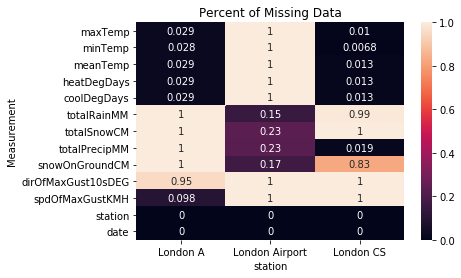

In [20]:
_ = sns.heatmap(df.groupby('station').apply(lambda x: pd.isnull(x).sum()).divide(df.groupby('station').size(), axis=0).transpose(), annot=True)
_.set_title("Percent of Missing Data");
_.set_ylabel("Measurement");

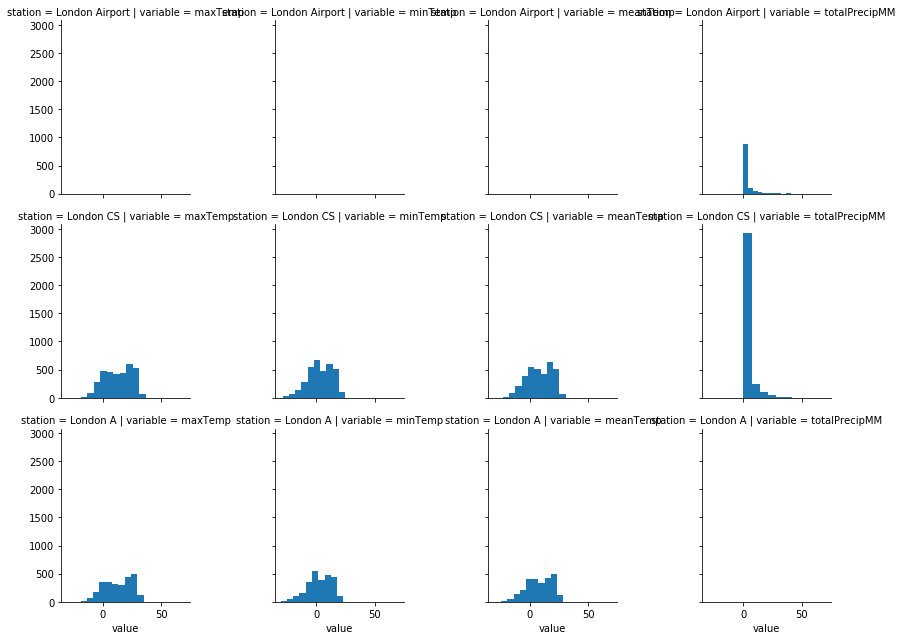

In [26]:
df_long = pd.melt(df[vs],  id_vars=['station'], value_vars=vs[1:])
g = sns.FacetGrid(df_long, col='variable',  row='station')
g.map(plt.hist, 'value');

Distributions look similar / consistent between stations with data. The London Airport station is missing temperature data and the London A station is missing precipitation data. The temperature distributions are bimodal, as expected, exhibiting a varying mean due to seasonality. The precipitation (rainfall) distributions appear to be gamma distributed which is consistent with [7].

#### Precipitation differences

The London CS station's data is most complete. How different are the observations between stations with precipitation data?

In [29]:
precip_stations = (
  df[['station', 'date','totalPrecipMM']]
    .query('station in ["London Airport", "London CS"]')
    .pivot(index='date', columns='station', values=['totalPrecipMM'])
)
precip_stations.columns = precip_stations.columns.droplevel(0)
precip_stations.head()

station,London Airport,London CS
date,,
2010-01-01,6.2,3.6
2010-01-02,4.7,3.5
2010-01-03,1.0,1.2
2010-01-04,1.0,0.0
2010-01-05,NaN,0.0


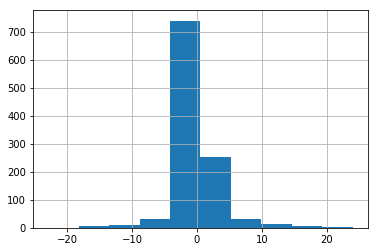

In [30]:
precip_stations['difference'] = precip_stations['London Airport'] - precip_stations['London CS']
precip_stations.difference.hist();

In [31]:
precip_stations.difference.describe()

count    1093.000000
mean     0.354163   
std      3.451900   
min     -22.900000  
25%     -0.200000   
50%      0.000000   
75%      0.700000   
max      24.000000  
Name: difference, dtype: float64

On average, it doesn't look like the precipitation measurements are significantly different between stations so we can use an average of the two stations to compute daily precipitation measurements. Are the extreme differences systematic?

In [32]:
precip_diff_outliers = precip_stations.query('(difference - difference.mean()) / difference.std() > 2').copy()
precip_diff_outliers

station,London Airport,London CS,difference
date,,,
2010-04-05,15.6,0.0,15.6
2010-11-22,25.4,12.1,13.3
2010-11-29,13.4,0.0,13.4
2010-12-05,29.0,7.2,21.8
2011-02-01,13.4,5.3,8.1
2011-02-27,17.4,0.6,16.8
2011-03-04,17.2,2.7,14.5
2011-11-22,20.1,11.4,8.7
2011-11-28,21.8,7.0,14.8


In [33]:
precip_diff_outliers['month'] = pd.to_datetime(precip_diff_outliers.index).month
precip_diff_outliers['year'] = pd.to_datetime(precip_diff_outliers.index).year

In [35]:
precip_diff_outliers.groupby('month').size().sort_values(ascending=False)

month
11    8
4     7
2     7
3     5
12    2
1     2
dtype: int64

In [37]:
precip_diff_outliers.groupby('year').size().sort_values(ascending=False)

year
2016    8
2011    6
2013    4
2010    4
2019    2
2018    2
2017    2
2015    2
2014    1
dtype: int64

Extreme differences in rainfall observations are typically observed earlier or later in the year, presumably when rainfall is more eratic, and has been less frequent over the last two years. It's interesting though that in every case, precipitation is higher at the London Airport station than at the London CS station. 

A possible explanation for the consistently higher difference at the London Airport station is that the airport uses cloud seeding [8] to improve visiblity. While we could perform a formal hypothesis test using simulation (since the sample size is small) to determine if the difference in proportions of larger differences is significant, with the Airport having a larger proportion of bigger differences, it is out of scope for this project.

#### Temperature differences

How different are the temperature observations between stations with precipitation data?

In [38]:
vs = ['minTemp', 'meanTemp', 'maxTemp']
temp_stations = (
  df[['station', 'date'] + vs]
    .query('station.isin(["London A", "London CS"])')
    .pivot(index='date', columns='station', values=vs)
)
temp_stations.tail()

minTemp           meanTemp            maxTemp          
station    London A London CS London A London CS London A London CS
date                                                               
2019-05-05  4.2      4.9       11.9     12.3      19.6     19.7    
2019-05-06  5.2      5.4       13.2     13.4      21.1     21.4    
2019-05-07  3.8      4.7       7.1      7.8       10.3     10.8    
2019-05-08  3.1      3.8       8.3      8.4       13.4     13.0    
2019-05-09  7.0      7.4       14.7     14.9      22.4     22.3

In [39]:
dfs = []
for var in temp_stations.columns.levels[0]:
  station_vals = temp_stations.xs(var, axis=1)
  stations_diffs = station_vals['London A'] - station_vals['London CS']
  station_diffs_df = pd.DataFrame({'difference': stations_diffs, 'variable': var})
  dfs.append(station_diffs_df)

var_diffs_df = pd.concat(dfs)

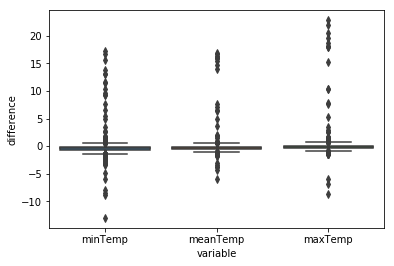

In [40]:
sns.boxplot(x='variable', y='difference', data=var_diffs_df);

All of the temperature variables are on average higher for the London A than the London CS station, indicating the possibility of some systematic difference in the sensors between stations. There are also some extreme differences at the tail end of the distributions which may simply be the result of device error.

In [41]:
extreme_temp_diffs_mean = var_diffs_df.query('(variable == "meanTemp") & ((difference - difference.mean()) * difference.std() > 2)')
extreme_temp_diffs_mean

,difference,variable
date,,
2010-03-20,15.4,meanTemp
2010-03-21,14.7,meanTemp
2010-03-22,16.0,meanTemp
2010-03-24,4.9,meanTemp
2010-03-25,6.4,meanTemp
2010-03-26,1.8,meanTemp
2010-03-28,6.5,meanTemp
2011-03-20,16.7,meanTemp
2011-03-21,13.9,meanTemp


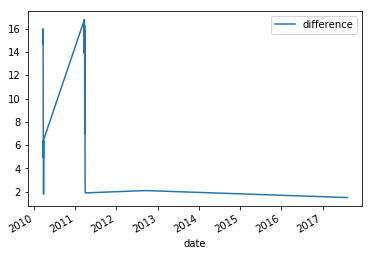

In [42]:
extreme_temp_diffs_mean.plot();

In [43]:
extreme_temp_diffs_min = var_diffs_df.query('(variable == "minTemp") & ((difference - difference.mean()) * difference.std() > 2)')
extreme_temp_diffs_min

,difference,variable
date,,
2010-03-20,10.4,minTemp
2010-03-21,11.4,minTemp
2010-03-22,9.3,minTemp
2010-03-23,13.7,minTemp
2010-03-24,9.2,minTemp
2010-03-25,5.0,minTemp
2010-03-28,2.5,minTemp
2010-03-31,1.6,minTemp
2011-03-20,15.6,minTemp


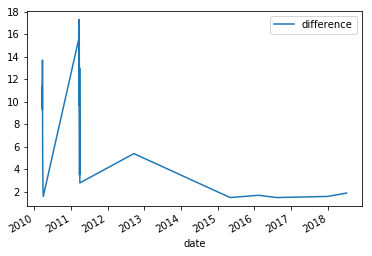

In [44]:
extreme_temp_diffs_min.plot();

In [45]:
extreme_temp_diffs_max = var_diffs_df.query('(variable == "maxTemp") & ((difference - difference.mean()) * difference.std() > 2)')
extreme_temp_diffs_max

,difference,variable
date,,
2010-03-20,20.5,maxTemp
2010-03-21,18.0,maxTemp
2010-03-22,22.8,maxTemp
2010-03-25,7.9,maxTemp
2010-03-26,2.5,maxTemp
2010-03-28,10.4,maxTemp
2011-03-20,17.9,maxTemp
2011-03-21,18.2,maxTemp
2011-03-22,22.0,maxTemp


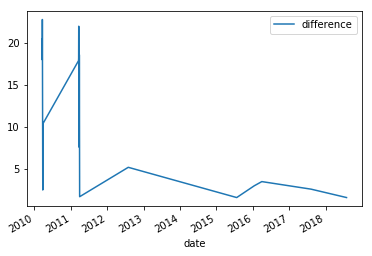

In [46]:
extreme_temp_diffs_max.plot();

It looks like extreme differences have been reduced over time and earlier differences in 2010-2011 may have been caused by a faulty sensor which was resolved in 2012. Since 2012, differences in min / max temperature readings between stations has not exceed 5 degrees Celsius and differences in `meanTemp` readings has not exceeded 2 degrees Celsius. With such neglible differences between station readings, there is no good reason for us not to calculate daily temperatures as the average between stations.

## Daily Observation Data
Since we are not ultimately not interested in measurements from individual weather stations (the purpose of this analysis is to analyze precipitation trends in London Ontario as a whole), and as a result of the above analysis, we can collapse observations from different locations into a single measurement by taking the arithmetic mean of measurements across stations.

In [47]:
daily_df = df[['date','totalPrecipMM', 'minTemp', 'maxTemp', 'meanTemp', 'totalSnowCM']].set_index('date').resample('1D').mean()
daily_df.head()

,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM
date,,,,,
2010-01-01,4.9,-9.2,0.0,-4.6,15.0
2010-01-02,4.1,-14.1,-9.2,-11.7,6.0
2010-01-03,1.1,-12.6,-5.6,-9.1,1.0
2010-01-04,0.5,-11.2,-7.5,-9.4,1.0
2010-01-05,0.0,-8.9,-3.5,-6.2,NaN


In [48]:
print("{} to {}".format(daily_df.index.min().date(), daily_df.index.max().date()))

2010-01-01 to 2019-05-09


### Seasons
Adding a seasonal indicator will allow us to visualize seasonal weather effects (if any).  Seasonal bounds for the Northern hemisphere are used to label each observation below
> [...] for temperate areas in the northern hemisphere, spring begins on 1 March, summer on 1 June, autumn on 1 September, and winter on 1 December. [9]

In [49]:
# Seasons
def season(date):
  if date.month == 12 or date.month < 3:
    # December - Feb
    return 'winter'
  elif date.month >= 3 and date.month < 6:
    # March - June
    return 'spring'
  elif date.month >= 6 and date.month < 9:
    # June - Sept
    return 'summer'
  else:
    # Sept - Nov
    return 'fall'

In [50]:
daily_df['season'] = pd.Series(daily_df.index).apply(season).values

### Dates
Add date components as separate columns so we can aggregate the data more easily

In [51]:
daily_df['year'] = pd.Series(daily_df.index).apply(lambda x: x.year).values
daily_df['month'] = pd.Series(daily_df.index).apply(lambda x: x.month).values
daily_df.head()

,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
date,,,,,,,,
2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


Save the data to CSV

In [52]:
csv_name = "../data/notebook1_weather_by_day_{}.csv".format(daily_df.index.max().date())
daily_df.to_csv(csv_name, index=True)
daily_df = pd.read_csv(csv_name, date_parser=['date'])
print(csv_name)
print(daily_df.info())
daily_df.head()

../data/notebook1_weather_by_day_2019-05-09.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3416 entries, 0 to 3415
Data columns (total 9 columns):
date             3416 non-null object
totalPrecipMM    3370 non-null float64
minTemp          3416 non-null float64
maxTemp          3415 non-null float64
meanTemp         3415 non-null float64
totalSnowCM      1109 non-null float64
season           3416 non-null object
year             3416 non-null int64
month            3416 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 240.3+ KB
None


,date,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
0,2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
1,2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2,2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
3,2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
4,2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


[1] Government of Canada (2019). Past weather and climate [Web application software]. Retrieved February 10, 2019, from http://climate.weather.gc.ca/historical_data/search_historic_data_e.html

[2] Wikipedia contributors. (2019, February 7). Weather station. In Wikipedia, The Free Encyclopedia. Retrieved February 10, 2019, from https://en.wikipedia.org/w/index.php?title=Weather_station&oldid=882144937

[3] Government of Canada. (2018, July 20). Glossary. Retrieved February 10, 2019, from http://climate.weather.gc.ca/glossary_e.html

[4] https://scrapy.org/

[5] https://developer.mozilla.org/en-US/docs/Web/XPath

[6] https://github.com/calvdee/ldn-ont-precip/tree/master/webcrawler

[7] http://journals.tubitak.gov.tr/engineering/issues/muh-00-24-6/muh-24-6-7-9909-13.pdf

[8] https://en.wikipedia.org/wiki/Cloud_seeding

[9] https://en.wikipedia.org/wiki/Season#Meteorological